20.94395102393195


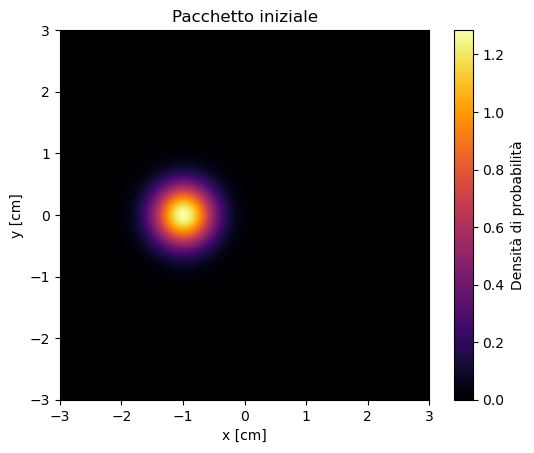

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.ticker import MultipleLocator
from scipy.signal import find_peaks

# physical quantities
e_charge = -1.602176634e-19
hbar = 1.05457182e-30
e_mass = 9.1093837e-31

# lattice size in space and time
L = 6 # in centimeter
T = 0.1 # in seconds
x_0 = 3 # in centimeter
y_0 = 3 # in centimeter

# lattice quantities
Nx = 200  # Numero di punti lungo l'asse x
Ny = 200 # Numero di punti lungo l'asse y
Nt = 50000 # Numero punti temporali

a_t = T / Nt
a_x = L / Nx
a_y = L / Ny

# lattice initialization
vec_x = np.linspace(-x_0, L - x_0, Nx)
vec_y = np.linspace(-y_0, L - y_0, Ny)

x, y = np.meshgrid(vec_x, vec_y)


#eps =  T / (L ** 2) * 0.001 * hbar / massa_e#L = 1cm, t = 1s

# Dimensione della griglia

# in centimetr




# Inizializzazione pacchetto d'onda Gaussiano

n_kx = 20
n_ky = 0

psi0= np.exp(-((y) ** 2 / (2 * 0.5 ** 2) + ( x + 1) ** 2 / (2 * 0.5 ** 2)) + 2 * math.pi / L * 1j * n_kx * x)
normal = np.sum(np.absolute(psi0) ** 2) * a_x * a_y
psi0 = psi0 / np.sqrt(normal)

# Creazione della funzione d'onda sulla griglia
psi_iniziale = np.zeros([2, Ny, Nx],dtype=np.complex64)
psi_iniziale[0] = psi0

# Plot del pacchetto iniziale
plt.imshow((np.absolute(psi0) ** 2), cmap='inferno', origin='lower', extent=[- x_0, L - x_0,- y_0, L - y_0])
plt.colorbar(label=f'Densità di probabilità')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('Pacchetto iniziale')

print(2 * math.pi / L * n_kx)
plt.show()

# Rapporto tra passo temporale e spaziale^


80 90 110 120 0.3 0.9 0.3000000000000007
-0.087941000553089 0.003340147479399276 0.0025726141421985914 -5.862733370205933e-06 6.680294958798551e-09


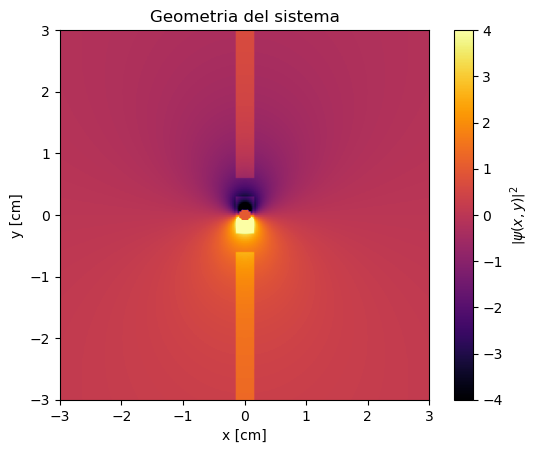

In [11]:
# Definizione del potenziale (gli indici risultano invertiti: la prima entrata corrisponde all'asse y
V = np.zeros([Ny,Nx])

l=0
d=0

# Posizionamento sull'asse x delle fenditure
Nminw = 95
Nmaxw = 105
# Trasformo le posizione in cm
xminw = Nminw * a_x + x_0
xmaxw = Nmaxw * a_x + x_0

# Posizionamento sull'asse y delle fenditure
ylefts1 = -0.6
yrights1 = -0.3
Nlefts1 = int((ylefts1 +y_0)/a_y)
Nrights1 = int((yrights1 +y_0)/a_y)

ylefts2 = 0.3
yrights2 = 0.6
Nlefts2 = int((ylefts2 +y_0)/a_y)
Nrights2 = int((yrights2 +y_0)/a_y)


# Lunghezze fenditure e loro separazione
l = round(np.absolute(ylefts1-yrights1),2)
d = round(np.absolute((ylefts1 + yrights1)/2 - (ylefts2 + yrights2)/2 ),2)

# valore del muro
for i in range(Nminw, Nmaxw):
    for j in range(0, Nlefts1):
        V[j, i] = 1
    for j in range(Nrights1, Nlefts2):
        V[j, i] = 1
    for j in range(Nrights2, Ny):
        V[j, i] = 1

# Controllo posizionamento delle fenditure
print(Nlefts1, Nrights1, Nlefts2, Nrights2,l ,d,xmaxw-xminw)

# Calcolo del campo vettoriale
Ncentrox = 100
centrox = Ncentrox * a_x - x_0


def pot_vettore(x, y):
    r_squared = (x-centrox)**2 + (y)**2
    mask = (r_squared < 0.01)
    #mask = (x < 0)
    u = np.where(mask, 0, -(y) / r_squared)
    v = np.where(mask, 0, (x-centrox) / r_squared)
    return u, v

Ax, Ay = pot_vettore(x, y)

'''
for i in range (0,92):
    for k in range (0,400):
        Ax[k,i]=0
        Ay[k,i]=0
    '''

#Ax = -y/(x**2+y**2)
#Ay = x/(x**2+y**2)

# B è il campo magnetico in microtesla, calcolato con raggio del soleniide pari a 0.1 mm
B = 0.1e-7
R = 0.01
phi = math.pi * R ** 2 * abs(B)

gamma1 = hbar / e_mass
gamma2 = phi * e_charge / (2 * math.pi * e_mass)
gamma3 = (phi * e_charge) ** 2 / (8 * math.pi ** 2 * e_mass * hbar)

C1_x = gamma1 * a_t / a_x ** 2
C1_y = gamma1 * a_t / a_y ** 2
C2_x = gamma2 * a_t / a_x
C2_y = gamma2 * a_t / a_y 
C3 = gamma3 * a_t


print(gamma2,gamma3,C1_x,C2_x,C3)


# Plot del potenziale
plt.imshow(Ax+V, cmap='inferno', origin='lower', extent=[- x_0, L - x_0, - y_0, L - y_0],vmax=4,vmin=-4)

# Aggiungi una barra dei colori
plt.colorbar(label=r"$\left|\psi(x,y)\right|^2$")

plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('Geometria del sistema')
#plt.savefig("risultati2/geom/V_A.png")
plt.show()

In [12]:
@numba.jit("c16[:,:,:](c16[:,:,:],float32,float32,float32,float32,float32)", nopython=True, nogil=True)
def calcolo_psi(psi,C1_x,C1_y,C2_x,C2_y,C3):
    for t in range(0, Nt-1):
        for i in range(0, Ny):
            ip=(Ny+i+1)%(Ny)
            im= (Ny+i-1)%(Ny)
            for k in range(0, Nx):
                kp=(Nx+k+1)%(Nx)
                km= (Nx+k-1)%(Nx)
                if V[i][k] == 0:      
                    psi[1][i][k] = psi[0][i][k] * (1 - 1j * a_t * V[i][k] - 1j * C1_x - 1j * C1_y - 1j * C3 * (Ax[i][k] ** 2 + Ay[i][k] ** 2) ) \
                 + psi[0][ip][k] * (1j * C1_y / 2. + C2_y / 2. * Ay[i][k]) \
                 + psi[0][im][k] * (1j * C1_y / 2. - C2_y / 2. * Ay[i][k]) \
                 + psi[0][i][kp] * (1j * C1_x / 2. + C2_x / 2. * Ax[i][k]) \
                 + psi[0][i][km] * (1j * C1_x / 2. - C2_x / 2. * Ax[i][k])
                else:
                     psi[1][i][k] = 0
                        
        psi[0] = psi[1]

    return psi

In [13]:
soluzione_imp = np.abs(calcolo_psi(psi_iniziale.astype(complex),C1_x,C1_y,0,0,0)[1])**2

In [14]:
soluzione_per = np.abs(calcolo_psi(psi_iniziale.astype(complex),C1_x,C1_y,C2_x,C2_y,C3)[1])**2

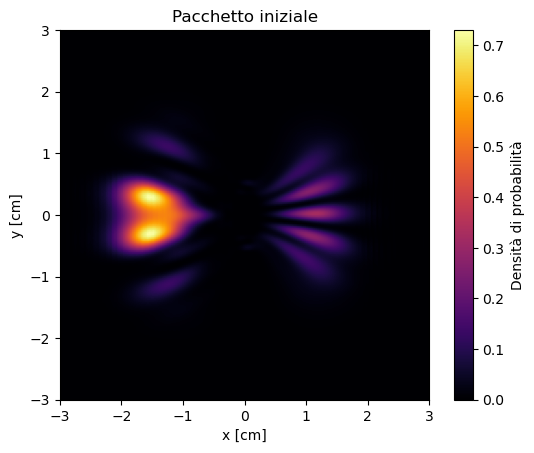

In [15]:
plt.imshow((soluzione_per), cmap='inferno', origin='lower', extent=[-3, 3, -3, 3])
plt.colorbar(label=f'Densità di probabilità')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('Pacchetto iniziale')

plt.show()

In [16]:
with open("ghB0.txt", "w") as file:
    for riga in soluzione_imp:
        file.write(f"[{', '.join(map(str, riga))}]\n")

In [17]:
with open("ghB01.txt", "w") as file:
    for riga in soluzione_per:
        file.write(f"[{', '.join(map(str, riga))}]\n")
      

 #with open("L200T0_info.txt", "w") as file:
 #   file.write(f"dt: {dt} {norm}\n dx: {dx} {norm}\n dt/dx^2: {dx**2/dt} {norm}")

In [18]:
imp = []

with open("ghB0.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        imp.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data_imp = np.array(imp)

per = []

with open("ghB01.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        per.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data_per = np.array(per)

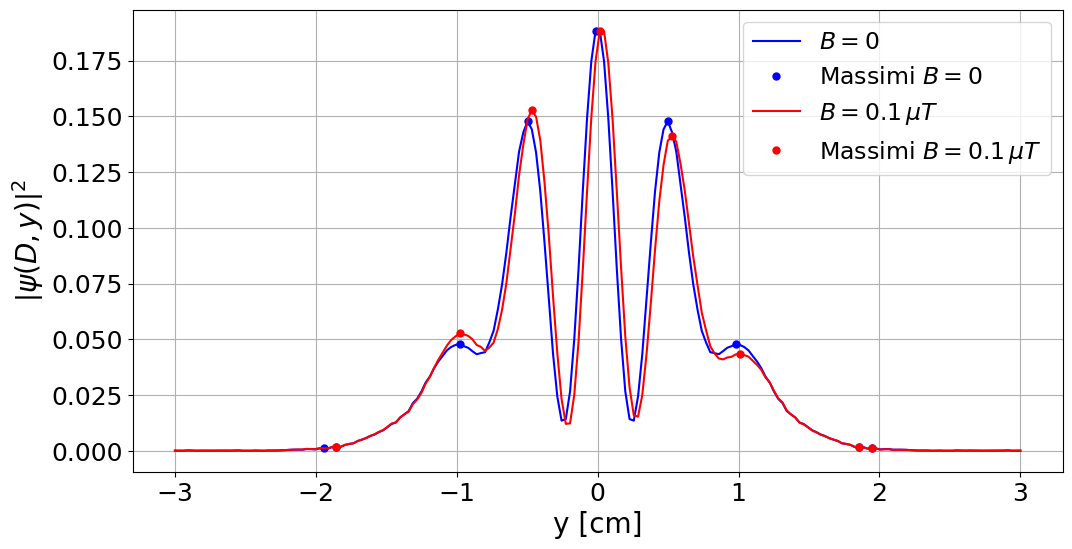

Media dei periodi tra i picchi nell'intervallo per $B=0$: 0.4861809045226131 0.017320508075688773
Media dei periodi tra i picchi nell'intervallo per $B=0.1$ : 0.542713567839196
[0.09045226 0.87437186 0.48241206 0.48241206 0.51256281 0.48241206
 0.87437186 0.09045226]


In [19]:
from scipy.signal import find_peaks
y_schermo = 1.5
Nxspot = int((y_schermo+x_0)/a_x)
# Calcola la funzione per B=0
signal_imp = data_imp[:, Nxspot]
signal_per = data_per[:, Nxspot]

# Definisci l'intervallo di interesse (ad esempio, tra t_min e t_max)
int_min = -2  # Sostituisci con il tuo valore minimo
int_max = 2# Sostituisci con il tuo valore massimo

# Trova gli indici dell'intervallo di interesse
indices_in_interval = np.where((vec_y >= int_min) & (vec_y <= int_max))[0]

# Estrai la parte dell'array signal nell'intervallo di interesse
signal_in_interval_imp = signal_imp[indices_in_interval]

# Trova i picchi nella parte dell'array nell'intervallo di interesse
peaks_imp, _ = find_peaks(signal_in_interval_imp)

# Calcola il periodo tra i picchi consecutivi
periods_imp = np.diff(vec_y[indices_in_interval][peaks_imp])

# Calcola la media dei periodi
media_periodi_imp = np.mean(periods_imp)
std_dev_periodi_imp = 4*(a_y)/np.sqrt(12)/np.sqrt(4)

# Apri il file in modalità scrittura ('w')
with open('massimi_imp.txt', 'w') as file:
    # Scrivi i dati di x_values seguiti da y_values su ciascuna riga
    for value in vec_y[indices_in_interval][peaks_imp]:
        file.write(str(value) + '\n')

# Plotta la funzione per B=0 e i picchi trovati
plt.figure(figsize=(12, 6))
plt.plot(vec_y, signal_imp, label='$B=0$', color='blue')
plt.plot(vec_y[indices_in_interval][peaks_imp], signal_in_interval_imp[peaks_imp], 'bo', markersize=5, label='Massimi $B=0$')

# Calcola la funzione per il campo mag
indices_in_interval = np.where((vec_y >= -2) & (vec_y <= 2))[0]
# Estrai la parte dell'array signal nell'intervallo di interesse
signal_in_interval_per = signal_per[indices_in_interval]

# Trova i picchi nella parte dell'array nell'intervallo di interesse
peaks_per, _ = find_peaks(signal_in_interval_per)

# Calcola il periodo tra i picchi consecutivi
periods_per = np.diff(vec_y[indices_in_interval][peaks_per])

# Calcola la media dei periodi
media_periodi_per = np.mean(periods_per)

# Plotta la funzione per il campo mag e i picchi trovati
plt.plot(vec_y, signal_per, label=f'$B={B}\,\mu T$', color='red')
plt.plot(vec_y[indices_in_interval][peaks_per], signal_in_interval_per[peaks_per], 'ro', markersize=5, label=f'Massimi $B={B}\,\mu T$')
#plt.title(f'Confronto figure di interferenza con $l={l}\,cm$ e $d={d}\,cm$',fontsize=12)
plt.xlabel('y [cm]',fontsize=20)
plt.ylabel(r"$\left|\psi(D,y)\right|^2$",fontsize=20)
plt.tick_params(axis='x', labelsize=18)  # Imposta la dimensione del font per l'asse x
plt.tick_params(axis='y', labelsize=18)
plt.legend(fontsize=17)
plt.grid(True)
plt.savefig("B8HD.pdf")
plt.show()

# Apri il file in modalità scrittura ('w')
with open('massimi_per.txt', 'w') as file:
    # Scrivi i dati di x_values seguiti da y_values su ciascuna riga
    for value in vec_y[indices_in_interval][peaks_per]:
        file.write(str(value) + '\n')




# Stampa la media dei periodi tra i picchi
print("Media dei periodi tra i picchi nell'intervallo per $B=0$:", media_periodi_imp,std_dev_periodi_imp)
print("Media dei periodi tra i picchi nell'intervallo per $B=0.1$", ":", media_periodi_per)
print(periods_imp)

In [15]:
from scipy import stats
std_dev = 4*a_y/np.sqrt(4)
# Leggi i dati dal file 1
with open('massimi_per.txt', 'r') as file1:
    data1 = np.loadtxt(file1)

# Leggi i dati dal file 2
with open('massimi_imp.txt', 'r') as file2:
    data2 = np.loadtxt(file2)

# Verifica se i due insiemi di dati hanno lo stesso numero di righe
if data1.shape[0] != data2.shape[0]:
    print("I file non hanno lo stesso numero di righe.")
else:
    # Calcola la differenza tra i valori dei due file per ogni riga
    difference = data1 - data2

    # Puoi ora fare qualcosa con l'array "difference" risultante
    # Ad esempio, stampare la differenza
    print("Differenza tra i valori:")
    print(difference)
    
    media_differenze = np.mean(difference)

    # Calcola la deviazione standard delle differenze, si sommano i due errori associati pari a 2dx/sqrt(12)
    
    stima_B = -hbar/carica*(media_differenze)/5/media_periodi_imp
    #propagazione errori
    errore_B = np.sqrt((hbar/e_charge/5/media_periodi_imp*std_dev)**2 + \
                       (hbar/e_char/5*media_differenze/media_periodi_imp**2*std_dev)**2)
   
    prob = 2 * (1 - stats.t.cdf(abs((B-stima_B)/errore_B), df=4))

    print("Media delle differenze:", media_differenze)
    print("Deviazione standard delle differenze:", std_dev)
    print("Campo magnetico in microtesla:", stima_B, errore_B)
    print("Campo magnetico vero:", B)
    print("prob:",prob)
    # Se vuoi salvare la differenza su un file:
    with open('differenza.txt', 'w') as diff_file:
        np.savetxt(diff_file, difference, delimiter='\t', fmt='%.6f')
    
    #sigma del pacchetto con stesse condizioni iniziali con singolanfenditura
    sigma_fs=0.4881

    with open('errors/infoB05HD.txt', 'w') as file:
        file.write("Lattice: x = ({},{}) , y = ({},{}) , t = ({},{}) , Nx,Ny,Nt= ({},{},{})\n".format(x_min,x_max,y_min,y_max,tempo_min,tempo_max,Nx,Ny,Nt))

        file.write("Dati del problema: k0 = {} , l = {} , d = {} , D = {}\n".format(kx0,l,d,1.5))
        file.write("Larghezza del pacchetto con fenditura singola: {}\n".format(sigma_fs))
        file.write("Differenza periodi: {}\n".format(np.abs(media_periodi_imp-media_periodi_per)))
        file.write("Media delle fasi: {}\n".format(media_differenze))
        file.write("Errore fase media: {}\n".format(std_dev))
        file.write("Campo magnetico stimato in microtesla: {} pm {}\n".format(stima_B,errore_B))
        file.write("Campo magnetico vero in microtesla: {}\n".format(B))
        file.write("Probabilità associata: {}\n".format(prob))

Differenza tra i valori:
[0.27135678 0.30150754 0.30150754 0.30150754 0.96482412]


NameError: name 'carica' is not defined

0.44999999999999996


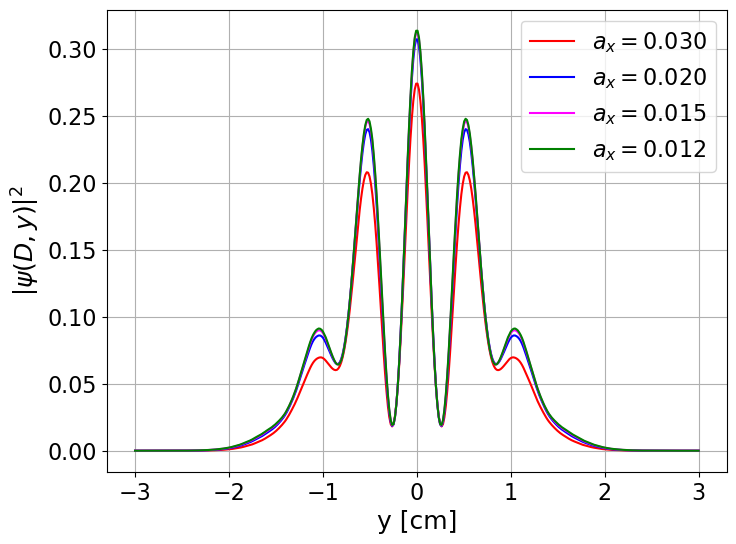

In [4]:
y_schermo = 1.5
Nxspot = int((y_schermo-x_min)/dx)

sigma_fs=0.517
mean_fs= np.abs(ylefts1+yrights1)/2
def funzione_analitica(x):
    # Scrivi la tu funzione qui, ad esempio:
        return (0.122*(np.exp(-(x+mean_fs)**2/(sigma_fs)**2/2)+np.exp(-(x-mean_fs)**2/(sigma_fs)**2/2) + 2*np.exp(-(x+mean_fs)**2/(sigma_fs)**2/4)*np.exp(-(x-mean_fs)**2/(sigma_fs)**2/4)*np.cos(x*2*np.pi/(0.525+0.04*x**2)) ))
vec_funz=funzione_analitica(vec_y)

sigma_fs=0.55
mean_fs= np.abs(ylefts1+yrights1)/2
def funzione_sup(x):
    # Scrivi la tua funzione qui, ad esempio:
        return 0.01*(np.exp(-(x-mean_fs)**2/(sigma_fs)**2/4)+np.exp(-(x+mean_fs)**2/(sigma_fs)**2/4))**2
    
vec_sup=funzione_sup(vec_y)

def funzione_inf(x):
    # Scrivi la tua funzione qui, ad esempio:
        return 0.11*(np.exp(-(x-mean_fs)**2/(sigma_fs)**2/4) - np.exp(-(x+mean_fs)**2/(sigma_fs)**2/4))**2
    
vec_inf=funzione_inf(vec_y)

    
    # Crea il grafico
fig, ax = plt.subplots(figsize=(8, 6))

# Plotta il primo grafico con un colore specifico (ad esempio, blu)
#line1 = ax.plot(vec_y, data_imp[:, Nxspot], label='Figura numerica', color='blue')
#line1 = ax.plot(vec_y, vec_funz, label='Figura analitica', color='red')
########################################################################
imp = []

with open("errors/B00LD.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        imp.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data_LD = np.array(imp)

imp = []

with open("errors/B00HD.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        imp.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data_HD = np.array(imp)
#line3 = ax.plot(vec_yld, d

imp = []

with open("errors/B00SHD.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        imp.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data_SHD = np.array(imp)

imp = []

with open("errors/B00SSHD.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        imp.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data_SSHD = np.array(imp)

differenza2 = [a - b for a, b in zip(data_SHD[:,300], data_HD[:,225])]
differenza1 = [a - b for a, b in zip(data_HD[:,225], data_LD[:,150])]
differenza3 = [a - b for a, b in zip(data_SSHD[:,375], data_SHD[:,300])]
########################################################################
line1 = ax.plot(vec_y, data_LD[:, 150], label=f'$a_x=0.030$', color='red')
line1 = ax.plot(vec_y, data_HD[:, 225], label=f'$a_x=0.020$', color='blue')
line1 = ax.plot(vec_y, data_SHD[:, 300], label=f'$a_x=0.015$', color='magenta')

line1 = ax.plot(vec_y, data_SSHD[:, 375], label=f'$a_x=0.012$', color='green')
#line1 = ax.plot(vec_y, differenza1, label=f'$a_x=0.020$', color='red')
#line1 = ax.plot(vec_y, differenza2, label=f'$a_x=0.015$', color='blue')
#line1 = ax.plot(vec_y, differenza3, label=f'$a_x=0.012$', color='green')


#line3 = ax.plot(vec_yld, d
#line3 = ax.plot(vec_yld, data_norm[:, 150], label='Figura numerica', linestyle='--',color='black')

# Plotta il secondo grafico con un altro colore (ad esempio, rosso) sovrapposto al primo
#line2 = ax.plot(vec_y, vec_inf, label='Limite inferiore', color='blue',linestyle='--')
#line2 = ax.plot(vec_y, vec_sup, label='Limite superiore', color='red',linestyle='--')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(axis='x', labelsize=16)  # Imposta la dimensione del font per l'asse x
ax.tick_params(axis='y', labelsize=16)
# Imposta il titolo e le etichette degli assi
#plt.title(f'Interferenza con $l={l}\,cm$ e $d={d}\,cm$')
plt.xlabel("y [cm]",fontsize=18)
plt.ylabel(r"$\left|\psi(D,y)\right|^2$",fontsize=18)

# Aggiungi una legenda per distinguere i due grafici
ax.legend(fontsize=16)
plt.grid(True)

# Salva il grafico in un file
plt.savefig("confronto.pdf")
print(mean_fs)
# Mostra il grafico
plt.show()

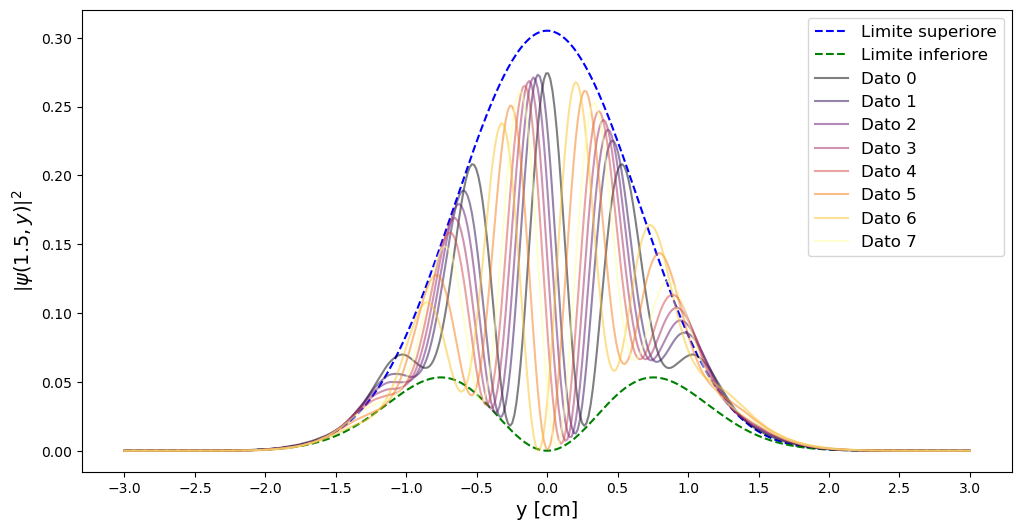

In [132]:
import matplotlib.pyplot as plt
from matplotlib.cm import inferno
import numpy as np

per = []
with open("varb/B00.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        per.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data0 = np.array(per)

per = []
with open("varb/B02.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        per.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data02 = np.array(per)

per = []
with open("varb/B03.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        per.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data03 = np.array(per)

per = []
with open("varb/B04.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        per.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data04 = np.array(per)

per = []
with open("varb/B05.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        per.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data05 = np.array(per)

per = []
with open("varb/B08.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        per.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data08 = np.array(per)

per = []
with open("varb/B1.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        per.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data1 = np.array(per)

per = []
with open("varb/B06.txt", "r") as file:
    for riga in file:
        valori_str = riga.strip()[1:-1].split(', ')
        valori_float = [float(valore) for valore in valori_str]
        per.append(valori_float)
# Converte la lista bidimensionale in un array NumPy
data06 = np.array(per)


sigma_fs=0.4966
mean_fs= np.abs(ylefts1+yrights1)/2
def funzione_sup(x):
    # Scrivi la tua funzione qui, ad esempio:
        return 0.115*(np.exp(-(x-mean_fs)**2/(sigma_fs)**2/4)+np.exp(-(x+mean_fs)**2/(sigma_fs)**2/4))**2
    
vec_funz=funzione_sup(vec_y)

def funzione_inf(x):
    # Scrivi la tua funzione qui, ad esempio:
        return 0.115*(np.exp(-(x-mean_fs)**2/(sigma_fs)**2/4) - np.exp(-(x+mean_fs)**2/(sigma_fs)**2/4))**2
    
vec_inf=funzione_inf(vec_y)


# ... (Codice per leggere i dati e impostare il grafico)

# Crea un gradiente di colori usando il colormap "inferno" con 8 livelli
cmap = inferno(np.linspace(0, 1, 8))

# Crea il grafico
fig, ax = plt.subplots(figsize=(12, 6))

linesup = ax.plot(vec_y, vec_funz, label='Limite superiore', color='blue', linestyle='--')
lineinf = ax.plot(vec_y, vec_inf, label='Limite inferiore', color='green', linestyle='--')

# Plotta i grafici dei dati con colori dal gradiente "inferno"
for i, data in enumerate([data0, data02, data03, data04, data05, data08, data1, data06]):
    line = ax.plot(vec_y, data[:, Nxspot], label=f'Dato {i}', color=cmap[i], alpha=0.5)

ax.xaxis.set_major_locator(MultipleLocator(0.5))

# Imposta il titolo e le etichette degli assi
plt.xlabel("y [cm]", fontsize=14)
plt.ylabel(r"$\left|\psi(1.5,y)\right|^2$", fontsize=14)

# Aggiungi una legenda per distinguere i grafici
ax.legend(fontsize=12)

# Salva il grafico in un file
plt.savefig("varblim.png")

# Mostra il grafico
plt.show()


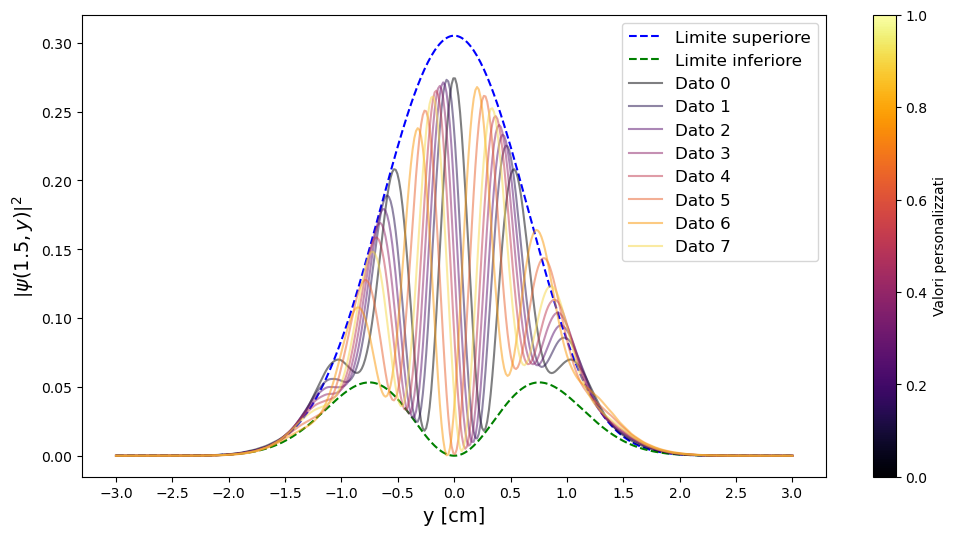

In [133]:
import matplotlib.pyplot as plt
from matplotlib.cm import inferno
import numpy as np

# ... (Codice per leggere i dati e impostare il grafico)

# Crea un gradiente di colori usando il colormap "inferno" con 8 livelli
cmap = inferno(np.linspace(0, 0.9, 8))

# Crea il grafico
fig, ax = plt.subplots(figsize=(12, 6))

linesup = ax.plot(vec_y, vec_funz, label='Limite superiore', color='blue', linestyle='--')
lineinf = ax.plot(vec_y, vec_inf, label='Limite inferiore', color='green', linestyle='--')

# Plotta i grafici dei dati con colori dal gradiente "inferno"
for i, data in enumerate([data0, data02, data03, data04, data05, data08, data1, data06]):
    line = ax.plot(vec_y, data[:, Nxspot], label=f'Dato {i}', color=cmap[i], alpha=0.5)

ax.xaxis.set_major_locator(MultipleLocator(0.5))

# Imposta il titolo e le etichette degli assi
plt.xlabel("y [cm]", fontsize=14)
plt.ylabel(r"$\left|\psi(1.5,y)\right|^2$", fontsize=14)

# Aggiungi una legenda per distinguere i grafici
ax.legend(fontsize=12)

# Crea la barra dei colori con il gradiente completo
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.inferno), ax=ax, label='Valori personalizzati')

# Salva il grafico in un file
plt.savefig("varblim.png")

# Mostra il grafico
plt.show()


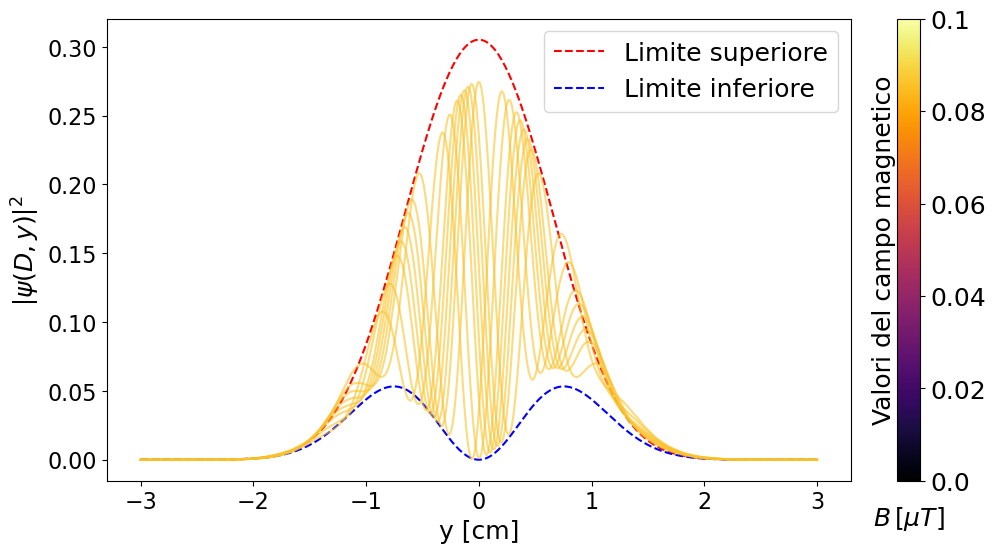

In [134]:
import matplotlib.pyplot as plt
from matplotlib.cm import inferno
from matplotlib.colors import Normalize
import numpy as np

# ... (Codice per leggere i dati e impostare il grafico)

# Crea un gradiente di colori usando il colormap "inferno" con 8 livelli
cmap = inferno(np.linspace(0, 1, 8))

# Crea il grafico
fig, ax = plt.subplots(figsize=(12, 6))

linesup = ax.plot(vec_y, vec_funz, label='Limite superiore', color='red', linestyle='--')
lineinf = ax.plot(vec_y, vec_inf, label='Limite inferiore', color='blue', linestyle='--')

# Plotta i grafici dei dati con colori dal gradiente "inferno"
for i, data in enumerate([data0, data02, data03, data04, data05, data08, data1, data06]):
    line = ax.plot(vec_y, data[:, Nxspot],  color=cmap[6], alpha=0.6)

ax.xaxis.set_major_locator(MultipleLocator(1))

# Imposta il titolo e le etichette degli assi
plt.xlabel("y [cm]", fontsize=18)
plt.ylabel(r"$\left|\psi(D,y)\right|^2$", fontsize=18)

# Aggiungi una legenda per distinguere i grafici
ax.legend(fontsize=18)
ax.tick_params(axis='x', labelsize=16)  # Imposta la dimensione del font per l'asse x
ax.tick_params(axis='y', labelsize=16)
# Crea la barra dei colori con il gradiente completo da 0 a 1
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=Normalize(vmin=0, vmax=1)), ax=ax)
cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))  # Imposta il formato dei valori
cbar.ax.tick_params(labelsize=18)  # Imposta la dimensione del font dell'etichetta
cbar.ax.set_ylabel('Valori del campo magnetico', fontsize=18)
cbar.ax.set_xlabel(f'$B\,[\mu T]$', fontsize=18)
cbar.ax.yaxis.set_label_coords(-1.1, 0.5) 
cbar.ax.xaxis.set_label_coords(0.5, -0.05) 
# Imposta la scala della figura da 0 a 0.1
# Imposta la scala della figura da 0 a 0.1
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(np.linspace(0, 0.1,6))
#cbar.ax.set_position([0.78, 0.15, 0.03, 0.7])

# Salva il grafico in un file
plt.savefig("varb/varblim01.pdf")

# Mostra il grafico
plt.show()
